In [1]:
import json
import numpy as np
from math import log
import pandas as pd
import os

# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)


In [2]:
name = "uni_full_koleo_4096_prototypes"

invasive_path = os.path.join(config['retrained_benchmark_folder2'], 
                                  "invasive_cancer_clustering",
                                   "kmeans")

In [3]:
optimal_clusters = pd.read_csv(os.path.join(invasive_path, "optimal_clusters.csv"), index_col=0)


In [4]:
import glob

filename = glob.glob(os.path.join(invasive_path,
                                    name, 
                                    f"invasive_labels_{optimal_clusters.loc[name, 'n_clusters']}_clusters_umap_min_dist*"))[0]
df = pd.read_csv(filename, index_col=0)

In [5]:
metadata = pd.read_excel("/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/ST_TNBC_metadata.xlsx")

In [6]:
# Statistical test: Log-rank test to compare survival curves
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

In [7]:
# Extract patient IDs from the spot names in df
# Assuming spot names have format like "TNBC78_1x2" where "TNBC78" is the patient ID
df['patient_id'] = df.index.str.split('_').str[0]

# Count spots per cluster per patient
cluster_counts = df.groupby(['patient_id', 'predicted_label']).size().reset_index(name='count')

# Calculate total spots per patient
total_spots = df.groupby('patient_id').size().reset_index(name='total')

# Merge and calculate percentages
cluster_composition = cluster_counts.merge(total_spots, on='patient_id')
cluster_composition['percentage'] = (cluster_composition['count'] / cluster_composition['total']) * 100

# Pivot to get one row per patient with columns for each cluster
cluster_composition_wide = cluster_composition.pivot(
    index='patient_id', 
    columns='predicted_label', 
    values='percentage'
).fillna(0)

# Rename columns to be more descriptive
cluster_composition_wide.columns = [f'cluster_{col}_pct' for col in cluster_composition_wide.columns]

print(f"Cluster composition for {len(cluster_composition_wide)} patients:")
cluster_composition_wide

Cluster composition for 85 patients:


,cluster_0_pct,cluster_1_pct,cluster_2_pct,cluster_3_pct,cluster_4_pct,cluster_5_pct
patient_id,,,,,,
TNBC1,80.952381,0.000000,0.000000,19.047619,0.000000,0.000000
TNBC11,5.750351,0.000000,93.688640,0.561010,0.000000,0.000000
TNBC12,26.666667,0.000000,13.333333,56.666667,3.333333,0.000000
TNBC13,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000
TNBC14,18.922652,35.911602,0.414365,33.287293,11.049724,0.414365
...,...,...,...,...,...,...
TNBC92,24.296296,22.444444,1.185185,41.481481,8.444444,2.148148
TNBC93,4.759329,1.189832,0.108167,6.652244,85.343429,1.946998
TNBC94,23.295455,0.284091,62.713068,12.215909,1.278409,0.213068


In [8]:
# Merge cluster composition with clinical metadata
# First, match patient IDs between cluster data and metadata
metadata['patient_id'] = metadata['ST_TNBC_ID'].apply(lambda x: f"TNBC{x}")  # Adjust column name if needed



Merged data for 85 patients with survival information:
Cluster columns: ['cluster_0_pct', 'cluster_1_pct', 'cluster_2_pct', 'cluster_3_pct', 'cluster_4_pct', 'cluster_5_pct']


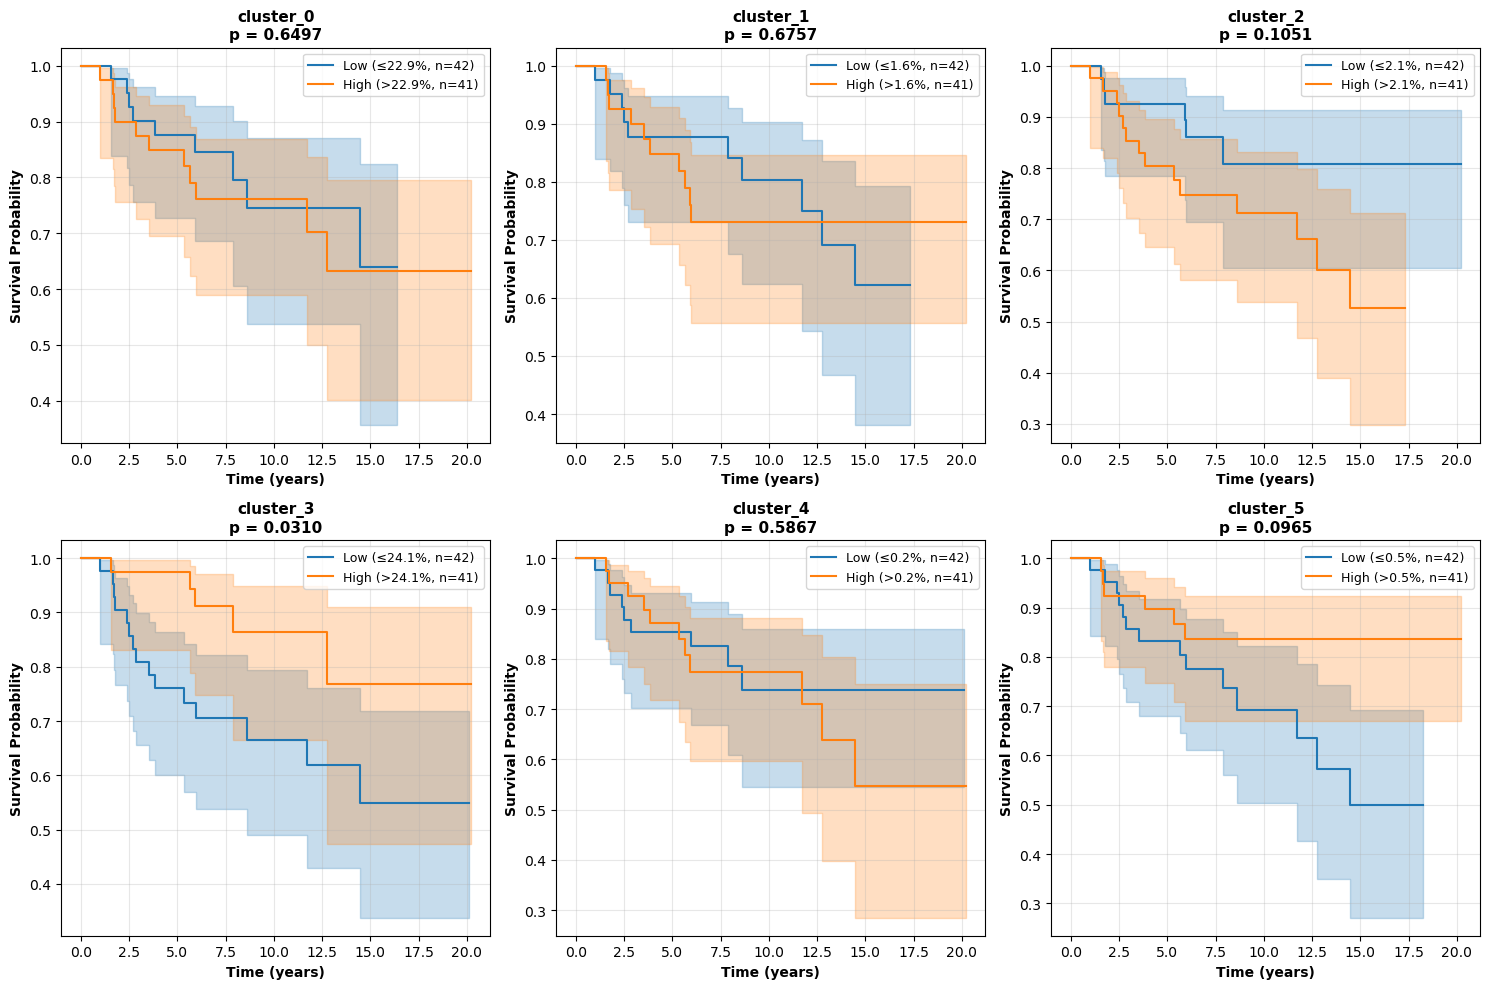


Log-rank test results for all clusters:


,cluster,median_split,n_low,n_high,p_value,test_statistic
0,cluster_0,22.857143,42,41,0.649723,0.206250
1,cluster_1,1.612903,42,41,0.675724,0.174980
2,cluster_2,2.139037,42,41,0.105094,2.626482
3,cluster_3,24.081633,42,41,0.030967,4.654775
4,cluster_4,0.202429,42,41,0.586670,0.295575
5,cluster_5,0.530504,42,41,0.096528,2.761987


In [9]:
# Create groups based on cluster composition
# Strategy: For each cluster, divide patients into high vs low percentage groups using median split

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Merge the dataframes
patient_data = cluster_composition_wide.merge(
    metadata[['patient_id', 'OS_years', 'OS-event', 'Age_at_diagnosis']], 
    left_index=True, 
    right_on='patient_id',
    how='inner'
)

print(f"Merged data for {len(patient_data)} patients with survival information:")
print(f"Cluster columns: {[col for col in patient_data.columns if 'cluster' in col]}")
patient_data.head()

# Get cluster columns
cluster_cols = [col for col in patient_data.columns if col.startswith('cluster_')]

# Create a figure with subplots for each cluster
n_clusters = len(cluster_cols)
n_cols = 3
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_clusters > 1 else [axes]

kmf = KaplanMeierFitter()

results_summary = []

for idx, cluster_col in enumerate(cluster_cols):
    ax = axes[idx]
    
    # Remove NaN values for this cluster
    data_clean = patient_data[['OS_years', 'OS-event', cluster_col]].dropna()
    
    # Split by median
    median_val = data_clean[cluster_col].median()
    
    # Create groups
    high_group = data_clean[data_clean[cluster_col] > median_val]
    low_group = data_clean[data_clean[cluster_col] <= median_val]
    
    # Plot low group
    kmf.fit(low_group['OS_years'], 
            low_group['OS-event'], 
            label=f'Low (≤{median_val:.1f}%, n={len(low_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Plot high group
    kmf.fit(high_group['OS_years'], 
            high_group['OS-event'], 
            label=f'High (>{median_val:.1f}%, n={len(high_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Log-rank test
    results = logrank_test(
        low_group['OS_years'], 
        high_group['OS_years'],
        event_observed_A=low_group['OS-event'],
        event_observed_B=high_group['OS-event']
    )
    
    # Store results
    cluster_name = cluster_col.replace('_pct', '')
    results_summary.append({
        'cluster': cluster_name,
        'median_split': median_val,
        'n_low': len(low_group),
        'n_high': len(high_group),
        'p_value': results.p_value,
        'test_statistic': results.test_statistic
    })
    
    # Formatting
    ax.set_xlabel('Time (years)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Survival Probability', fontsize=10, fontweight='bold')
    ax.set_title(f'{cluster_name}\np = {results.p_value:.4f}', 
                 fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(loc='best', fontsize=9)

# Remove empty subplots
for idx in range(n_clusters, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Display summary
results_df = pd.DataFrame(results_summary)
print("\nLog-rank test results for all clusters:")
results_df

Merged data for 85 patients with survival information:
Cluster columns: ['cluster_0_pct', 'cluster_1_pct', 'cluster_2_pct', 'cluster_3_pct', 'cluster_4_pct', 'cluster_5_pct']


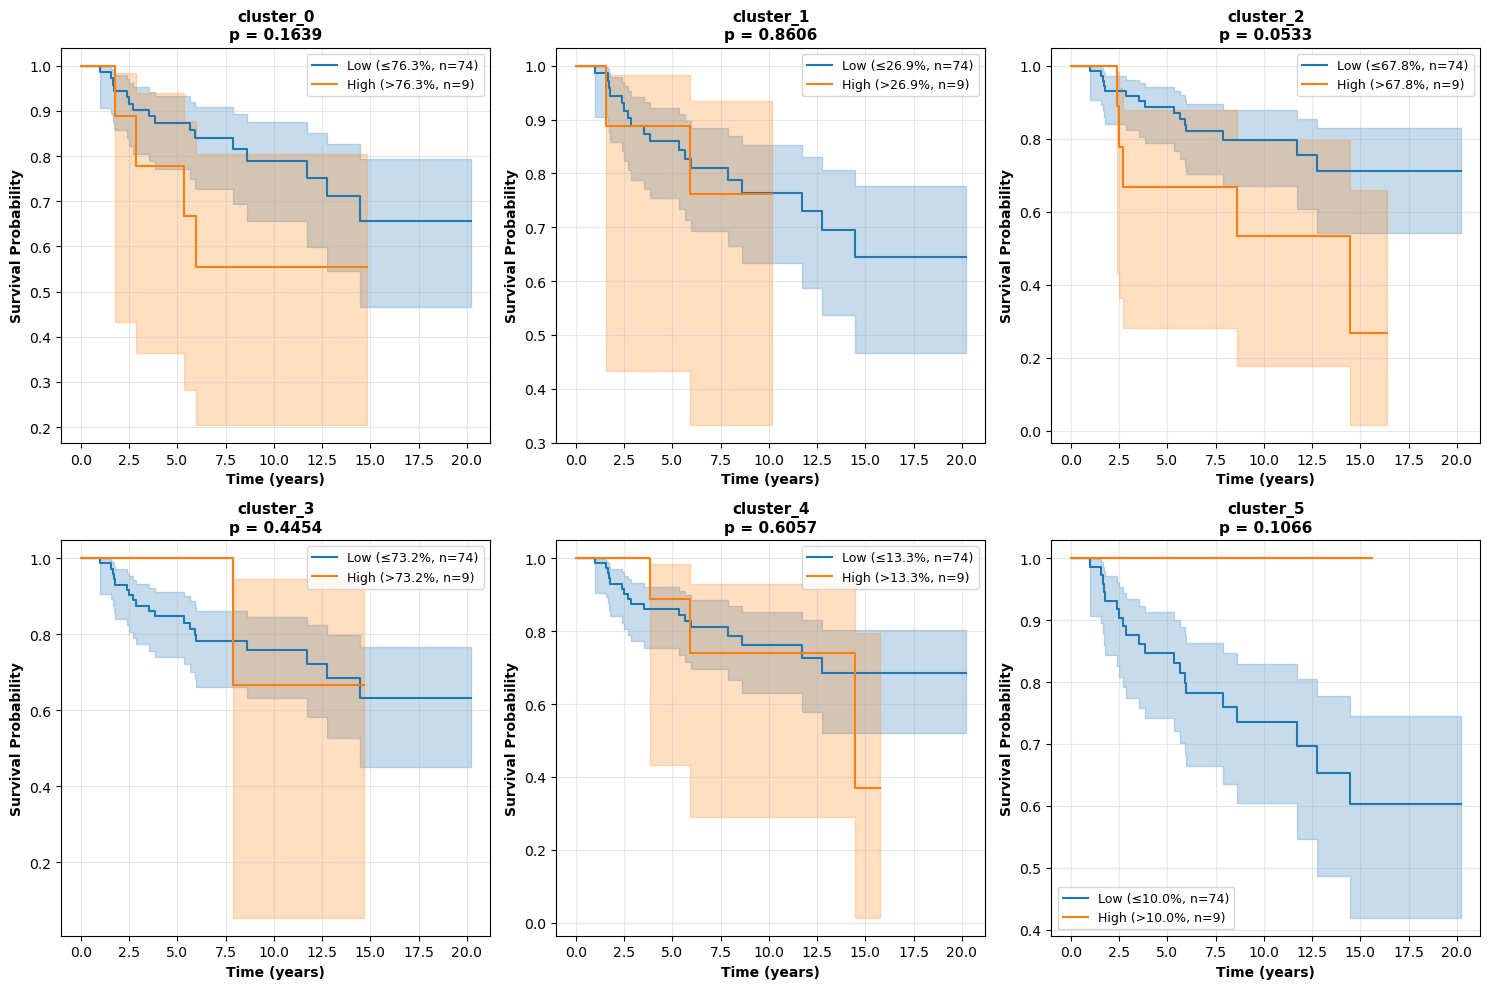


Log-rank test results for all clusters:


,cluster,median_split,n_low,n_high,p_value,test_statistic
0,cluster_0,0.530504,74,9,0.163853,1.938305
1,cluster_1,0.530504,74,9,0.860644,0.030819
2,cluster_2,0.530504,74,9,0.053302,3.734433
3,cluster_3,0.530504,74,9,0.445409,0.582308
4,cluster_4,0.530504,74,9,0.605716,0.266461
5,cluster_5,0.530504,74,9,0.106592,2.604034


In [17]:

# Merge the dataframes
patient_data = cluster_composition_wide.merge(
    metadata[['patient_id', 'OS_years', 'OS-event', 'Age_at_diagnosis']], 
    left_index=True, 
    right_on='patient_id',
    how='inner'
)

print(f"Merged data for {len(patient_data)} patients with survival information:")
print(f"Cluster columns: {[col for col in patient_data.columns if 'cluster' in col]}")
patient_data.head()

# Get cluster columns
cluster_cols = [col for col in patient_data.columns if col.startswith('cluster_')]

# Create a figure with subplots for each cluster
n_clusters = len(cluster_cols)
n_cols = 3
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_clusters > 1 else [axes]

kmf = KaplanMeierFitter()

results_summary = []

for idx, cluster_col in enumerate(cluster_cols):
    ax = axes[idx]
    
    # Remove NaN values for this cluster
    data_clean = patient_data[['OS_years', 'OS-event', cluster_col]].dropna()
    
    # Split by median
    split_n = data_clean[cluster_col].quantile(0.9)
    
    # Create groups
    high_group = data_clean[data_clean[cluster_col] > split_n]
    low_group = data_clean[data_clean[cluster_col] <= split_n]
    
    # Plot low group
    kmf.fit(low_group['OS_years'], 
            low_group['OS-event'], 
            label=f'Low (≤{split_n:.1f}%, n={len(low_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Plot high group
    kmf.fit(high_group['OS_years'], 
            high_group['OS-event'], 
            label=f'High (>{split_n:.1f}%, n={len(high_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Log-rank test
    results = logrank_test(
        low_group['OS_years'], 
        high_group['OS_years'],
        event_observed_A=low_group['OS-event'],
        event_observed_B=high_group['OS-event']
    )
    
    # Store results
    cluster_name = cluster_col.replace('_pct', '')
    results_summary.append({
        'cluster': cluster_name,
        'median_split': median_val,
        'n_low': len(low_group),
        'n_high': len(high_group),
        'p_value': results.p_value,
        'test_statistic': results.test_statistic
    })
    
    # Formatting
    ax.set_xlabel('Time (years)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Survival Probability', fontsize=10, fontweight='bold')
    ax.set_title(f'{cluster_name}\np = {results.p_value:.4f}', 
                 fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(loc='best', fontsize=9)

# Remove empty subplots
for idx in range(n_clusters, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Display summary
results_df = pd.DataFrame(results_summary)
print("\nLog-rank test results for all clusters:")
results_df

In [11]:
# Highlight significant clusters (p < 0.05)
significant_clusters = results_df[results_df['p_value'] < 0.05].sort_values('p_value')

if len(significant_clusters) > 0:
    print(f"\n⭐ Significant clusters (p < 0.05):")
    print(significant_clusters)
else:
    print("\nNo clusters showed significant association with survival (p < 0.05)")


No clusters showed significant association with survival (p < 0.05)


In [19]:
from lifelines import CoxPHFitter


In [102]:
patient_data.index = patient_data['patient_id']

In [103]:
patient_data

,cluster_0_pct,cluster_1_pct,cluster_2_pct,cluster_3_pct,cluster_4_pct,cluster_5_pct,patient_id,OS_years,OS-event,Age_at_diagnosis
patient_id,,,,,,,,,,
TNBC1,80.952381,0.000000,0.000000,19.047619,0.000000,0.000000,TNBC1,8.284932,0.0,66
TNBC11,5.750351,0.000000,93.688640,0.561010,0.000000,0.000000,TNBC11,2.375342,1.0,67
TNBC12,26.666667,0.000000,13.333333,56.666667,3.333333,0.000000,TNBC12,5.156164,0.0,61
TNBC13,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,TNBC13,6.756164,0.0,72
TNBC14,18.922652,35.911602,0.414365,33.287293,11.049724,0.414365,TNBC14,6.816438,0.0,35
...,...,...,...,...,...,...,...,...,...,...
TNBC92,24.296296,22.444444,1.185185,41.481481,8.444444,2.148148,TNBC92,20.186301,0.0,34
TNBC93,4.759329,1.189832,0.108167,6.652244,85.343429,1.946998,TNBC93,15.769863,0.0,57
TNBC94,23.295455,0.284091,62.713068,12.215909,1.278409,0.213068,TNBC94,3.183562,0.0,75


In [109]:
cluster_cols = [col for col in patient_data.columns if col.startswith('cluster_')]
df = patient_data.dropna()

# Handle zeros and normalize
df[cluster_cols] = df[cluster_cols].clip(lower=1e-6)
df[cluster_cols] = df[cluster_cols].div(df[cluster_cols].sum(axis=1), axis=0)

# CLR transform
log_vals = np.log(df[cluster_cols])
clr_vals = log_vals.sub(log_vals.mean(axis=1), axis=0)
clr_df = clr_vals.add_suffix("_clr")

# Combine with survival data
cox_df = pd.concat([df[["OS_years","OS-event"]], clr_df], axis=1)

/tmp/ipykernel_2366868/583869532.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cluster_cols] = df[cluster_cols].clip(lower=1e-6)
/tmp/ipykernel_2366868/583869532.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cluster_cols] = df[cluster_cols].div(df[cluster_cols].sum(axis=1), axis=0)


In [110]:
clr_df

,cluster_0_pct_clr,cluster_1_pct_clr,cluster_2_pct_clr,cluster_3_pct_clr,cluster_4_pct_clr,cluster_5_pct_clr
patient_id,,,,,,
TNBC1,12.380734,-5.828637,-5.828637,10.933815,-5.828637,-5.828637
TNBC11,7.705146,-7.859625,10.495862,5.377868,-7.859625,-7.859625
TNBC12,6.036111,-11.062814,5.342964,6.789883,3.956670,-11.062814
TNBC13,-3.070113,-3.070113,-3.070113,15.350567,-3.070113,-3.070113
TNBC14,1.162529,1.803230,-2.658839,1.727345,0.624575,-2.658839
...,...,...,...,...,...,...
TNBC92,1.007886,0.928605,-2.012539,1.542809,-0.048929,-1.417832
TNBC93,0.473813,-0.912481,-3.310377,0.808660,3.360390,-0.420005
TNBC94,1.943162,-2.463558,2.933473,1.297643,-0.959480,-2.751240


In [100]:
df[cluster_cols]

,cluster_0_pct,cluster_1_pct,cluster_2_pct,cluster_3_pct,cluster_4_pct,cluster_5_pct
0,8.095238e-01,1.000000e-08,1.000000e-08,0.190476,1.000000e-08,1.000000e-08
2,5.750350e-02,1.000000e-08,9.368864e-01,0.005610,1.000000e-08,1.000000e-08
3,2.666667e-01,1.000000e-08,1.333333e-01,0.566667,3.333333e-02,1.000000e-08
4,1.000000e-08,1.000000e-08,1.000000e-08,1.000000,1.000000e-08,1.000000e-08
5,1.892265e-01,3.591160e-01,4.143646e-03,0.332873,1.104972e-01,4.143646e-03
...,...,...,...,...,...,...
89,2.429630e-01,2.244444e-01,1.185185e-02,0.414815,8.444444e-02,2.148148e-02
90,4.759329e-02,1.189832e-02,1.081666e-03,0.066522,8.534343e-01,1.946998e-02
91,2.329545e-01,2.840909e-03,6.271307e-01,0.122159,1.278409e-02,2.130682e-03
92,1.000000e-08,5.000000e-01,1.000000e-08,0.500000,1.000000e-08,1.000000e-08


In [92]:
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

# Fit Cox model (with or without penalizer)
cph = CoxPHFitter(penalizer=0.1)
cph.fit(cox_df, duration_col="OS_years", event_col="OS-event")

# Check proportional hazards assumption
results = proportional_hazard_test(cph, cox_df, time_transform='rank')
print(results)


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 83 total observations, 63 right-censored observations>
         test_name = proportional_hazard_test

---
                   test_statistic    p  -log2(p)
cluster_0_pct_clr            0.02 0.90      0.16
cluster_1_pct_clr            0.04 0.85      0.23
cluster_2_pct_clr            0.13 0.72      0.48
cluster_3_pct_clr            1.37 0.24      2.05
cluster_4_pct_clr            0.83 0.36      1.47
cluster_5_pct_clr            0.74 0.39      1.36


In [93]:
import matplotlib.pyplot as plt

# Martingale residuals
residuals = cph.compute_residuals(cox_df, kind='martingale')

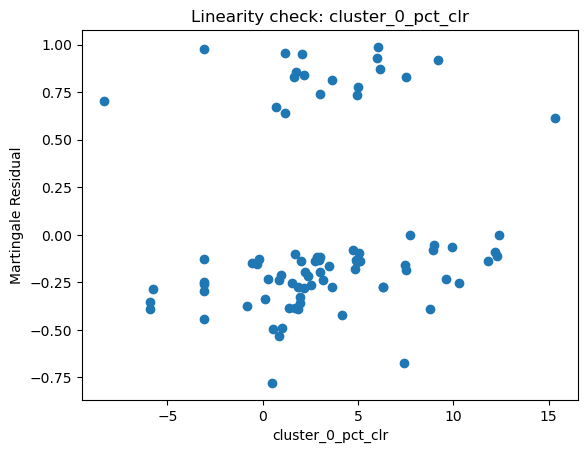

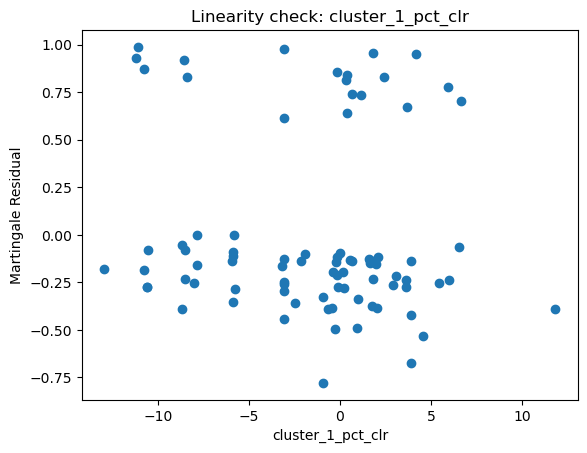

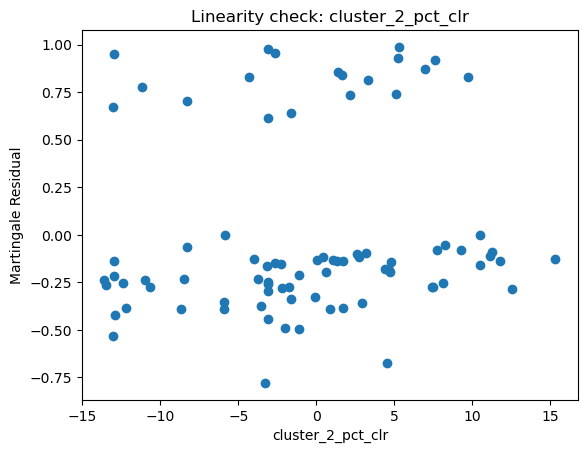

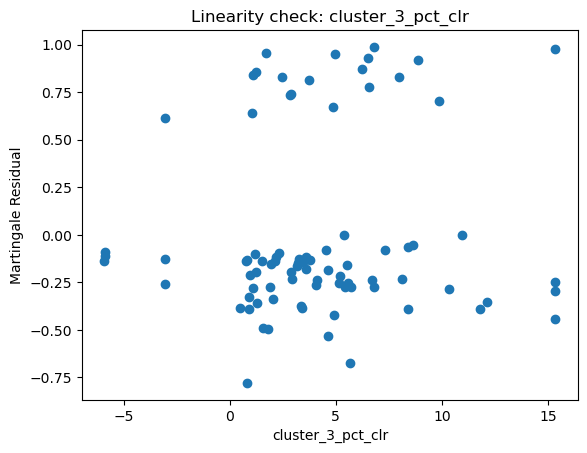

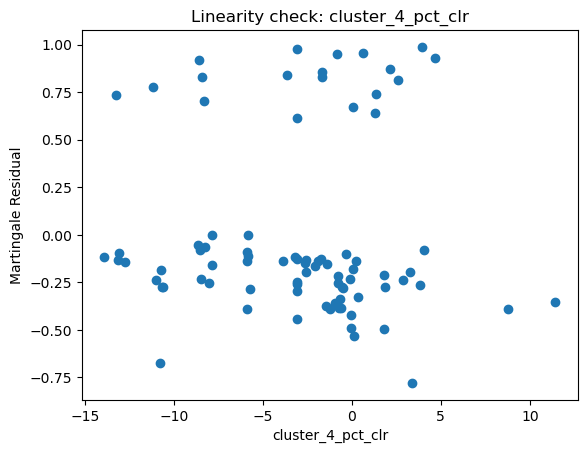

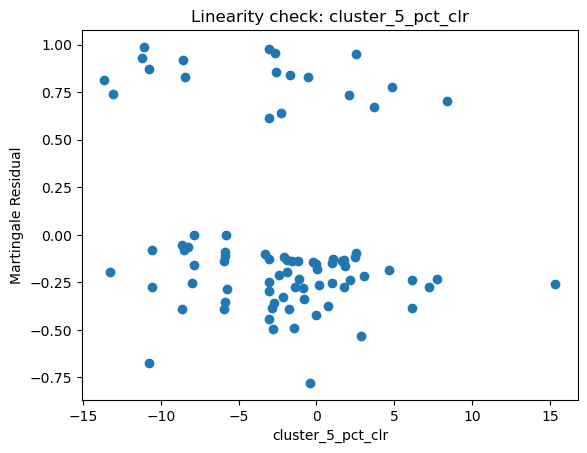

In [94]:


for col in clr_df.columns:
    plt.scatter(cox_df[col], residuals['martingale'])
    plt.xlabel(col)
    plt.ylabel("Martingale Residual")
    plt.title(f"Linearity check: {col}")
    plt.show()

In [95]:

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 83 total observations, 63 right-censored observations>
             duration col = 'OS_years'
                event col = 'OS-event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 83
number of events observed = 20
   partial log-likelihood = -76.48
         time fit was run = 2025-11-26 15:26:11 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
cluster_0_pct_clr  -0.00       1.00       0.05            -0.10             0.09                 0.90                 1.10
cluster_1_pct_clr   0.06       1.06       0.04            -0.03             0.15                 0.97                 1.16
cluster_2_pct_clr   0.02       1.02       0.03            -0.04             0.09                 0.96                 1.09
cluster_3_pct_clr  -0.04       0.96       0.05            -0.14             0.05                 0.87                 1.05
cluster_4_pct_clr   0.00       1.00       0.04            -0.08             0.08                 0.92                 1.09
cluster_5_pct_clr  -0.07       0.94       0.04            -0.15             0.02                 0.86                 1.02

                    cmp to     z    p   -log2(p)
covariate                                       
cluster_0_pct_clr     0.00 -0.08 0.94       0.09
cluster_1_pct_clr     0.00  1.33 0.18       2.46
cluster_2_pct_clr     0.00  0.65 0.52       0.95
cluster_3_pct_clr     0.00 -0.93 0.35       1.51
cluster_4_pct_clr     0.00  0.06 0.95       0.07
cluster_5_pct_clr     0.00 -1.57 0.12       3.09
---
Concordance = 0.74
Partial AIC = 164.97
log-likelihood ratio test = 6.39 on 6 df
-log2(p) of ll-ratio test = 1.39

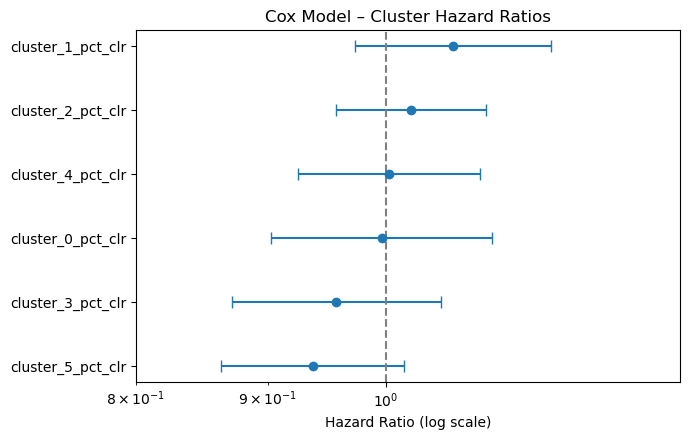

In [99]:
import numpy as np
import matplotlib.pyplot as plt

summary = cph.summary.copy()
summary = summary.sort_values("exp(coef)")  # Order visually

hr = summary["exp(coef)"]
ci_lower = summary["exp(coef) lower 95%"]
ci_upper = summary["exp(coef) upper 95%"]
labels = summary.index

plt.figure(figsize=(7, 4.5))
plt.errorbar(hr, labels, 
             xerr=[hr-ci_lower, ci_upper-hr], 
             fmt='o', capsize=4)

plt.axvline(1, color='grey', linestyle='--')
plt.xlabel("Hazard Ratio (log scale)")
plt.xscale("log")
plt.title("Cox Model – Cluster Hazard Ratios")
plt.xlim(0.8, 1.3)

plt.tight_layout()
plt.show()


In [111]:
cph.concordance_index_

0.7373607540702657

/tmp/ipykernel_2366868/1728157107.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["uni", "uni_full_koleo_4096_prototypes"],


([0, 1], [Text(0, 0, 'uni'), Text(1, 0, 'uni_full_koleo_4096_prototypes')])

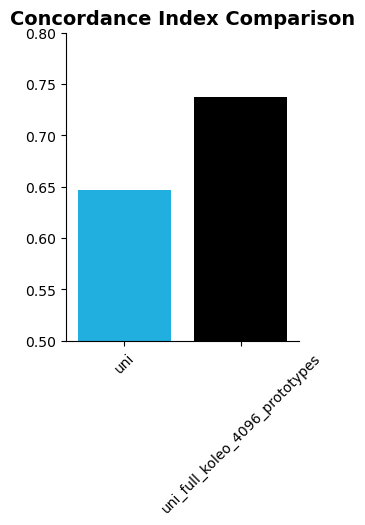

In [121]:
concordance_index_uni = 0.6465295629820051

import seaborn as sns


plt.figure(figsize=(3,4))
sns.barplot(x=["uni", "uni_full_koleo_4096_prototypes"],
            y=[concordance_index_uni, cph.concordance_index_], 
            palette=["deepskyblue", "black"])
sns.despine()
plt.title("Concordance Index Comparison", 
          fontsize=14, fontweight='bold',)
plt.ylim(0.5, 0.8)
plt.xticks(rotation=45)

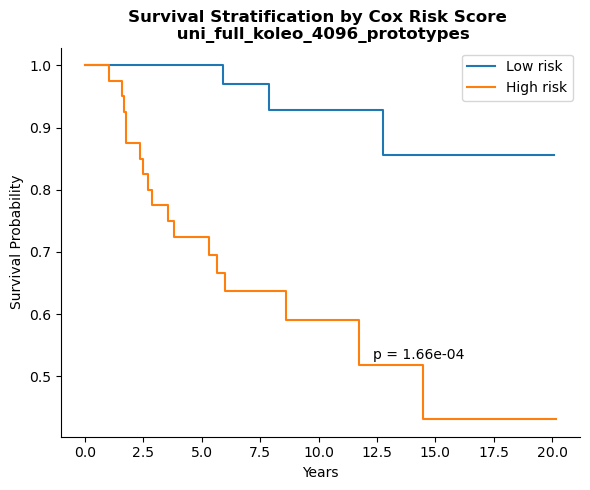

In [123]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import seaborn as sns
# Compute risk score (linear predictor)
cox_df["risk_score"] = cph.predict_partial_hazard(cox_df)

# Stratify into High vs Low using median
median = cox_df["risk_score"].median()
cox_df["risk_group"] = np.where(cox_df["risk_score"] > median, "High risk", "Low risk")

# Fit KMF curves
km = KaplanMeierFitter()

plt.figure(figsize=(6, 5))

for group in ["Low risk", "High risk"]:
    mask = cox_df["risk_group"] == group
    km.fit(cox_df.loc[mask, "OS_years"],
           cox_df.loc[mask, "OS-event"],
           label=group)
    km.plot(ci_show=False)

plt.title(f"Survival Stratification by Cox Risk Score \n uni_full_koleo_4096_prototypes", weight='bold')
plt.xlabel("Years")
plt.ylabel("Survival Probability")

# Log-rank test
res = logrank_test(
    cox_df.loc[cox_df["risk_group"]=="Low risk", "OS_years"],
    cox_df.loc[cox_df["risk_group"]=="High risk", "OS_years"],
    cox_df.loc[cox_df["risk_group"]=="Low risk", "OS-event"],
    cox_df.loc[cox_df["risk_group"]=="High risk", "OS-event"]
)
plt.text(0.6, 0.2, f"p = {res.p_value:.2e}",
         transform=plt.gca().transAxes)

plt.tight_layout()

sns.despine()